In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import scipy as sp
import os
from scipy.linalg import fractional_matrix_power

from jax import vmap, jit, numpy as jnp, random, lax, jvp, scipy as jsp
import matplotlib.pyplot as plt
import pickle
from functools import reduce

import matplotlib.animation as animation
from IPython.display import HTML

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from ad_afqmc import lattices

from pyscf import fci, gto, scf, mp, ao2mo

import itertools
from functools import partial

np.set_printoptions(precision=5, suppress=True)

In [11]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
import matplotlib.colors as mcolors
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('axes',labelsize=20)
plt.rc('axes',titlesize=20)
plt.rc('legend',fontsize=16)
plt.rc('lines', linewidth=2)
plt.rc('savefig', dpi=300)

plt.rcParams['figure.autolayout'] =  True
plt.rcParams["font.family"] = "Serif"
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = [10, 8]
colors = list(mcolors.TABLEAU_COLORS.values())

# Check triangular lattice with `xc` boundary condition

In [22]:
lattice = lattices.triangular_grid(6, 6, boundary='xc')
n_sites = lattice.n_sites
coords = np.array([lattice.get_site_coordinate(site) for site in lattice.sites])

In [23]:
adj_mat = lattice.create_adjacency_matrix()

/var/folders/7s/34k_vnn90590lbb66qchz3c80000gn/T/ipykernel_14872/287257437.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(3, 3, figsize=(14, 8))


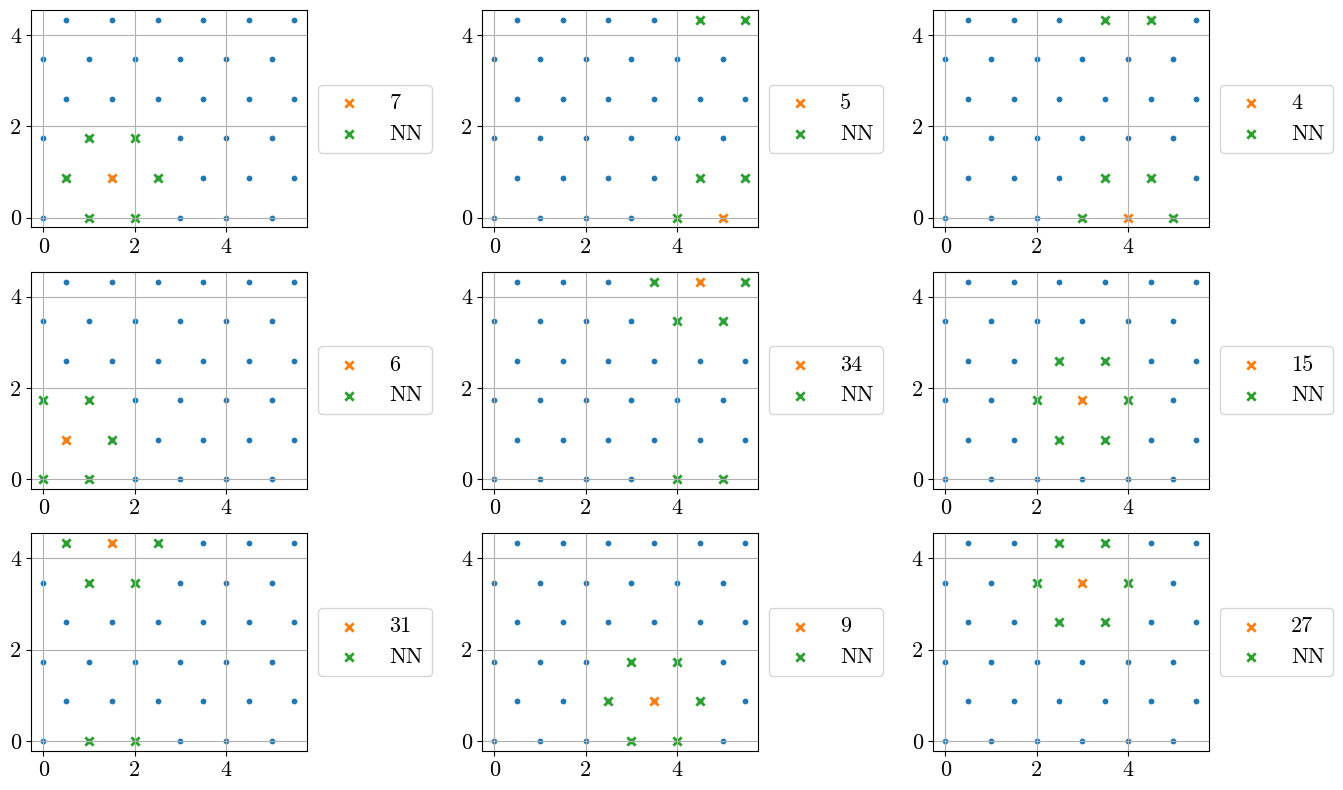

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_sites = np.array([(i // lattice.l_y, i % lattice.l_y) for i in nn_idx])
    nn_coords = np.array([lattice.get_site_coordinate(site) for site in nn_sites])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')

/var/folders/7s/34k_vnn90590lbb66qchz3c80000gn/T/ipykernel_14872/2775496136.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))


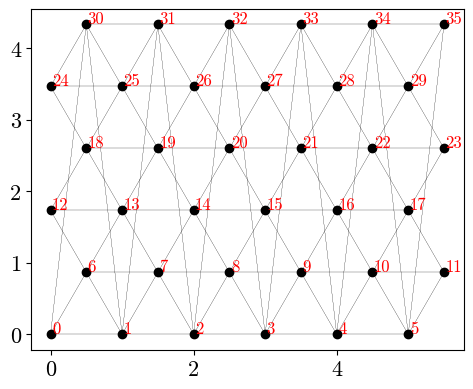

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(n_sites):
    coord = coords[i]
    x, y = coord
    ax.scatter(x, y, marker='o', color='k')

    # draw lines to nearest neighbors
    nn = np.nonzero(adj_mat[i])[0]
    
    for n in nn:
        site_n = coords[n]
        x_n, y_n = site_n
        ax.plot([x, x_n], [y, y_n], "k-", lw=0.1)

    # add site num
    shift = 0.02
    ax.annotate(str(i),  xy=(x+shift, y+shift), fontsize=12, color='r')

ax.set_aspect("equal")

# Check triangular lattice with `yc` boundary condition

In [27]:
lattice = lattices.triangular_grid(6, 6, boundary='yc')
n_sites = lattice.n_sites
coords = np.array([lattice.get_site_coordinate(site) for site in lattice.sites])

In [28]:
adj_mat = lattice.create_adjacency_matrix()

/var/folders/7s/34k_vnn90590lbb66qchz3c80000gn/T/ipykernel_14872/1268697832.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(3, 3, figsize=(10, 8))


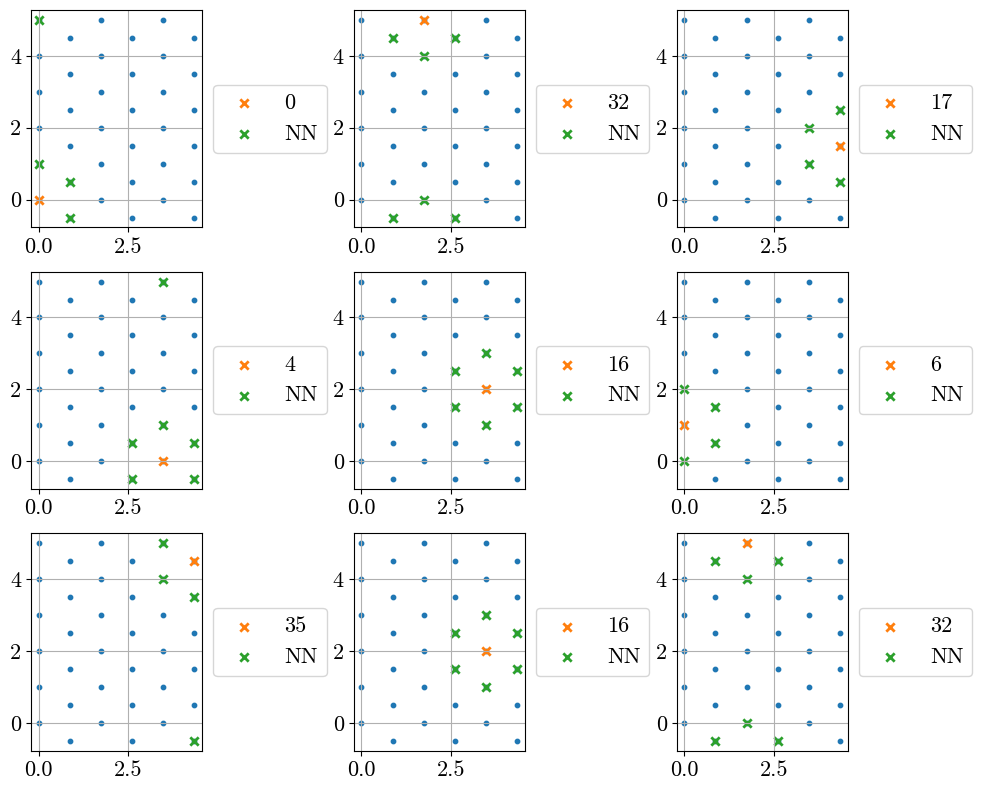

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_sites = np.array([(i // lattice.l_y, i % lattice.l_y) for i in nn_idx])
    nn_coords = np.array([lattice.get_site_coordinate(site) for site in nn_sites])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')

/var/folders/7s/34k_vnn90590lbb66qchz3c80000gn/T/ipykernel_14872/2775496136.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1, 1, figsize=(6, 4))


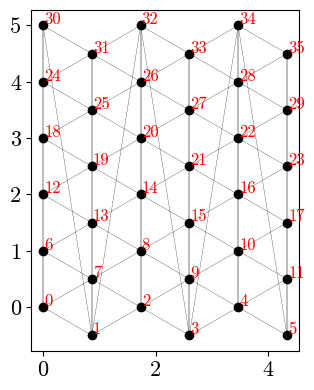

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(n_sites):
    coord = coords[i]
    x, y = coord
    ax.scatter(x, y, marker='o', color='k')

    # draw lines to nearest neighbors
    nn = np.nonzero(adj_mat[i])[0]
    
    for n in nn:
        site_n = coords[n]
        x_n, y_n = site_n
        ax.plot([x, x_n], [y, y_n], "k-", lw=0.1)

    # add site num
    shift = 0.02
    ax.annotate(str(i),  xy=(x+shift, y+shift), fontsize=12, color='r')

ax.set_aspect("equal")

# Check triangular lattice with `obc` boundary condition

In [31]:
lattice = lattices.triangular_grid(6, 6, boundary='obc')
n_sites = lattice.n_sites
coords = np.array([lattice.get_site_coordinate(site) for site in lattice.sites])

In [32]:
adj_mat = lattice.create_adjacency_matrix()

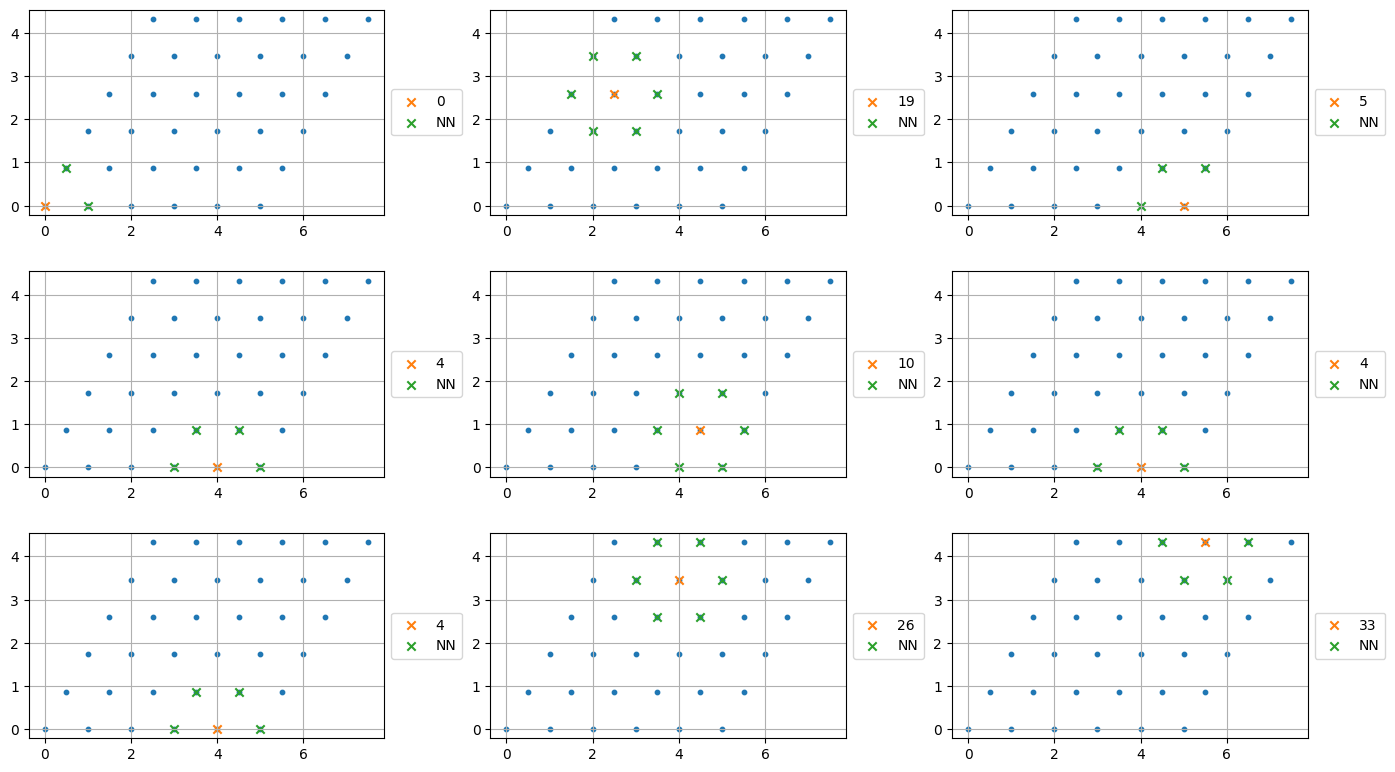

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_sites = np.array([(i // lattice.l_y, i % lattice.l_y) for i in nn_idx])
    nn_coords = np.array([lattice.get_site_coordinate(site) for site in nn_sites])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')

plt.tight_layout()

# Check rectangular lattice with `open_x` boundary condition

In [34]:
lattice = lattices.two_dimensional_grid(6, 6, open_x=True)
n_sites = lattice.n_sites
coords = np.array(lattice.sites)

In [35]:
adj_mat = lattice.create_adjacency_matrix()

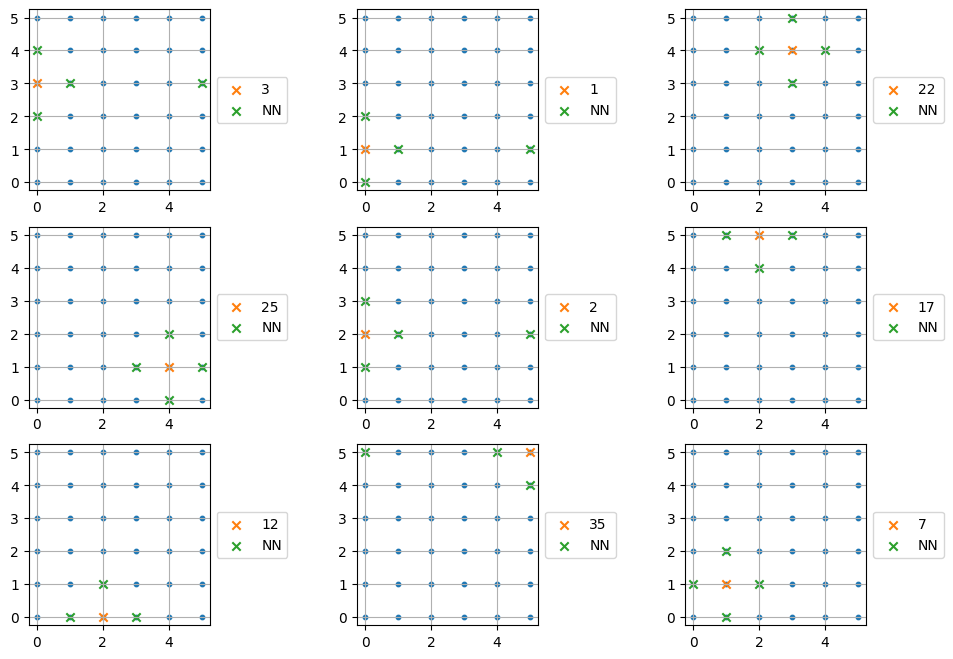

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_coords = np.array([coords[idx] for idx in nn_idx])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')